In [2]:
import dal, pandas, common
dal.init_db()
common.PERIODS_IN_HOUR = 4*60
common.PERIODS_IN_DAY = common.PERIODS_IN_HOUR * 24
from scipy.stats import multivariate_normal
from sklearn import model_selection
import seaborn as sns
import matplotlib.pyplot as plt

/usr/lib64/python2.7/site-packages/sklearn/utils/fixes.py:200: UserWarning: Using `sort` instead of partition.Upgrade numpy to 1.8 for better performace on large numberof clusters
  warnings.warn('Using `sort` instead of partition.'


In [3]:
%matplotlib inline

In [4]:
df = pandas.DataFrame(dal.get_ended_sessions())

data = pandas.DataFrame()
data['bandwidth'] = df['n_bytes']
data['duration'] = df['timestamp'] - df['start_time']
data['dest_ip'] = df['dest_ip']
data['src_ip'] = df['src_ip']

In [5]:
def calc_prob(row, model):
    return  model.pdf((row['duration'], row['bandwidth']))

def my_log(x):
    if isinstance(x, (int, long, float, complex)):
        return common.safe_log(common.safe_log(x))
    else:
        return x

def get_script_data(data):
    bots_ips = ['10.0.0.2','10.0.0.21','10.0.0.6','10.0.0.14','10.0.0.3', '88.198.23.221', '10.0.0.20', '10.0.0.12', '10.0.0.11',  '10.0.0.23', '10.0.0.18',  '10.0.0.24', '10.0.0.105',  '10.0.0.5', '10.0.0.104']
    return data[(data['dest_ip'].isin(bots_ips) | data['src_ip'].isin(bots_ips))]

def get_human_data(data):
    bots_ips = ['10.0.0.2','10.0.0.21','10.0.0.6','10.0.0.14','10.0.0.3', '88.198.23.221', '10.0.0.20', '10.0.0.12', '10.0.0.11',  '10.0.0.23', '10.0.0.18',  '10.0.0.24', '10.0.0.105',  '10.0.0.5', '10.0.0.104']
    return data[(data['dest_ip'].isin(bots_ips) | data['src_ip'].isin(bots_ips)) == False]



In [6]:
s_data = get_script_data(data)
h_data = get_human_data(data)

In [7]:
logged_s_data = s_data.applymap(lambda x: my_log(x))
logged_h_data = h_data.applymap(lambda x: my_log(x))

In [8]:
s_model = multivariate_normal(mean = logged_s_data[['bandwidth', 'duration']].mean(), cov=logged_s_data[['bandwidth', 'duration']].cov())
h_model = multivariate_normal(mean = logged_h_data[['bandwidth', 'duration']].mean(), cov=logged_h_data[['bandwidth', 'duration']].cov())

In [14]:
logged_s_data['prob'] = logged_s_data.apply(calc_prob, args=(s_model,), axis=1)
logged_h_data['prob'] = logged_h_data.apply(calc_prob, args=(h_model,), axis=1)

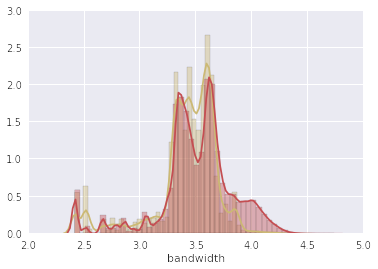

In [22]:
sns.set_color_codes()
sns.distplot(logged_h_data['bandwidth'], color='y', label="human")
sns.distplot(logged_s_data['bandwidth'], color='r', label="script")


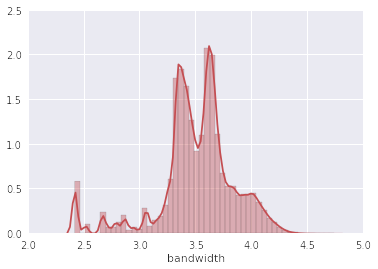

In [21]:
sns.distplot(logged_s_data['bandwidth'], color='r', label="script")

In [28]:
ingoing_s_data = logged_s_data[logged_s_data['dest_ip'].str.match('10.0.*')]
outgoing_s_data = logged_s_data[logged_s_data['src_ip'].str.match('10.0.*')]

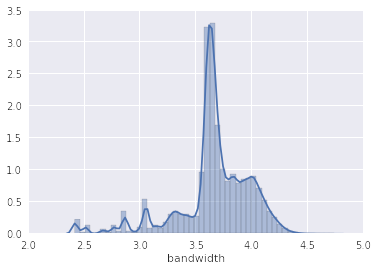

In [29]:
sns.distplot(ingoing_s_data['bandwidth'], color='b', label="script")

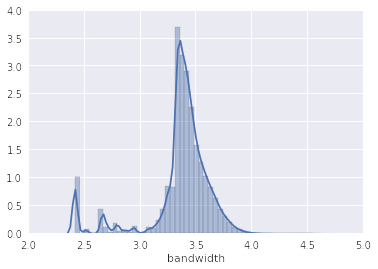

In [30]:
sns.distplot(outgoing_s_data['bandwidth'], color='b', label="script")